# Workshop 11.2.2022 - (4/4)

## Simulation of water movement in roots and soil domain using DuMux-Rosi

Next we couple the xylem water movement to a dynamic soil. We sequentially solve (a) root xylem water movement, and (b) soil water movement. Therefore, a rather small coupling time step is needed. 

Soil water movement is described by the Richards equation, and the van Genuchten model. We use DuMux to numerically solve these equation (i.e. the Python binding of DuMux-Rosi). 

We start with some additional imports, making the Richards solver available.

In [9]:
from IPython.display import SVG, display # to show svg files in the notebook

import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
import vtk_plot as vp
from xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../../../dumux-rosi/build-cmake/cpp/python_binding/")
sys.path.append("../../../../dumux-rosi/python/modules/")
sys.path.append("../../../../dumux-rosi/python/modules/fv/")
from rosi_richards import RichardsSP  # C++ part (Dumux binding)
from richards import RichardsWrapper  # Python part
from rhizo_models import plot_transpiration

def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

We start with the simulation parameters (for a static root system)

In [17]:
min_b = [-3., -3., -25.] # cm
max_b = [3., 3., 0.] # cm
cell_number = [6, 6, 25]    
periodic = False
loam = [0.08, 0.43, 0.04, 1.6, 50]
soil = loam
initial = -600 
trans = 6.4  # cm3 /day (sinusoidal)
wilting_point = -10000  # cm
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
sim_time = 5 # [day] 
dt = 360. / (24 * 3600)  # [days] Time step must be very small
initial_age = 10

The root system is calculated as but with a confining geometry 

In [19]:
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]:
    p.dx = 0.25 
if periodic:    
    rs.setGeometry(pb.SDF_PlantBox(1.e6, 1.e6, max_b[2]-min_b[2])) 
else:
    rs.setGeometry(pb.SDF_PlantBox(max_b[0]-min_b[0], max_b[1]-min_b[1], max_b[2]-min_b[2])) 
rs.initialize() # note that an artificial root of type 0 is added by MappedRootSystem
rs.simulate(initial_age)
_ = vp.plot_roots(pb.SegmentAnalyser(rs.mappedSegments()), "subType") 

Initialize macroscopic soil model

In [20]:
s = RichardsWrapper(RichardsSP())
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic)  # [cm] the picker s.pick(x,y,z) will be periodic or not
s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([soil])
s.setParameter("Newton.EnableChop", "True") # setParameter is used additional to the DuMux input files
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True")
s.setParameter("Soil.SourceSlope", "1000") 
s.initializeProblem()
s.setCriticalPressure(wilting_point)

In [21]:
""" Initialize xylem model """
r = XylemFluxPython(rs)
r.rs.setRectangularGrid(pb.Vector3d(min_b[0], min_b[1], min_b[2]), pb.Vector3d(max_b[0], max_b[1], max_b[2]),
                        pb.Vector3d(cell_number[0], cell_number[1], cell_number[2]), False)  
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial shoot segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([x, y, z])    
cci = picker(r.rs.nodes[0].x, r.rs.nodes[0].y, r.rs.nodes[0].z)  # collar cell index
r.rs.setSoilGrid(picker)  # maps segment
r.test()  # sanity checks


XylemFluxPython.test():
2087 segments
Segment 0 [0 1]
0 segments with length < 1.e-5 cm
5 different root types from 0 to 4
ages from 0 to 10



In [22]:
""" Numerical solution """
times_, soil_flux_, collar_flux_, sink1d_ = [], [], [], []
sx = s.getSolutionHead()  # inital condition, solverbase.py
N = round(sim_time / dt)
t = 0.
for i in range(0, N):
 
    # root part
    rx = r.solve(initial_age + t, -trans * sinusoidal(t), 0., sx, True, wilting_point, [])  # xylem_flux.py, cells = True
    fluxes = r.soilFluxes(initial_age + t, rx, sx, False)  # class XylemFlux is defined in MappedOrganism.h, approx = True
 
    # soil part
    s.setSource(fluxes.copy())  # richards.py 
    s.solve(dt)
    sx = s.getSolutionHead()  # richards.py
 
    # post processing
    times_.append(t)
    sum_flux = 0.
    for f in fluxes.values():
        sum_flux += f
    soil_flux_.append(sum_flux)  # cm3/day
    collar_flux_.append(float(r.collar_flux(initial_age + t, rx, sx)))  # cm3/day
        
    # Console output and sink data 
    if (i+1) % 60 == 0:  # every 60th time step = every 6h        
        print("Summed fluxes ", sum_flux, "= collar flux", collar_flux_[-1], "= prescribed", -trans * sinusoidal(t))
        min_sx, max_sx = np.min(sx), np.max(sx)        
        min_rx, max_rx = np.min(rx), np.max(rx)        
        n = round(float(i) / float(N-1) * 100.)
        print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], soil [{:g}, {:g}] cm, root [{:g}, {:g}] cm, {:g} days {:g}\n"
              .format(min_sx, max_sx, min_rx, max_rx, s.simTime, rx[0]))
        
        ana = pb.SegmentAnalyser(r.rs)
        fluxes = r.segFluxes(initial_age + t, rx, sx, False, cells=True)  # cm3/day
        ana.addData("fluxes", fluxes) 
        flux1d = ana.distribution("fluxes", max_b[2], min_b[2], 15, True) 
        sink1d_.append(np.array(flux1d))

    t += dt

Summed fluxes  -6.232467530787669 = collar flux -6.232467530829581 = prescribed -6.232467530829627
[*****                                                                                               ], soil [-827.8, -588] cm, root [-2053.5, -966.925] cm, 0.25 days -2053.5

Summed fluxes  -12.797806879764236 = collar flux -12.797806879843543 = prescribed -12.797806879843566
[**********                                                                                          ], soil [-2902.1, -588.002] cm, root [-4208.7, -1816.43] cm, 0.5 days -4208.7

Summed fluxes  -6.567532469092691 = collar flux -6.567532469170449 = prescribed -6.567532469170446
[***************                                                                                     ], soil [-3338.53, -588.042] cm, root [-3709.32, -2245.12] cm, 0.75 days -3709.32

Summed fluxes  -0.0021931201174345723 = collar flux -0.0021931201564104885 = prescribed -0.0021931201564356685
[********************                            

/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Summed fluxes  -5.573508370156287 = collar flux -5.573508370077737 = prescribed -12.797806879843586
[**************************************************                                                  ], soil [-9692.21, -605.728] cm, root [-10000, -8710.95] cm, 2.5 days -10000

Summed fluxes  -4.027696613830378 = collar flux -4.027696613594647 = prescribed -6.567532469169132
[*******************************************************                                             ], soil [-9797.51, -612.53] cm, root [-10000, -9081.52] cm, 2.75 days -10000

Summed fluxes  -0.002193120024869294 = collar flux -0.0021931201563347713 = prescribed -0.002193120156388062
[************************************************************                                        ], soil [-8536.32, -620.373] cm, root [-6995.45, -6914.73] cm, 3 days -6994.17

Summed fluxes  -6.232467530563422 = collar flux -6.232467530831855 = prescribed -6.2324675308318565
[****************************************************

Save results and plot

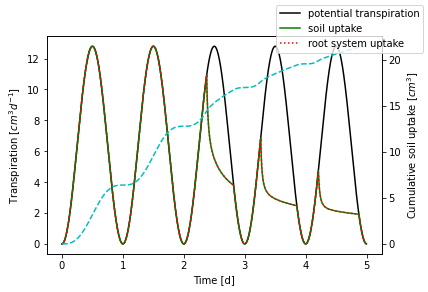

In [23]:
s.writeDumuxVTK("dumux-rosi-example")
vp.plot_roots_and_soil(r.rs, "pressure head", rx, s, periodic, min_b, max_b, cell_number, name)
plot_transpiration(times_, soil_flux_, collar_flux_, lambda t: trans * sinusoidal(t))
np.savetxt(name, np.vstack((times_, -np.array(soil_flux_))), delimiter=';')
np.save("sink1d", np.array(sink1d_))

Things we can easily modify in the script
* change initial root system age
* change the soil type and initial potential 
* add root growth (rs.simulate(dt))
* add age dependent conductivities

Where to find what:

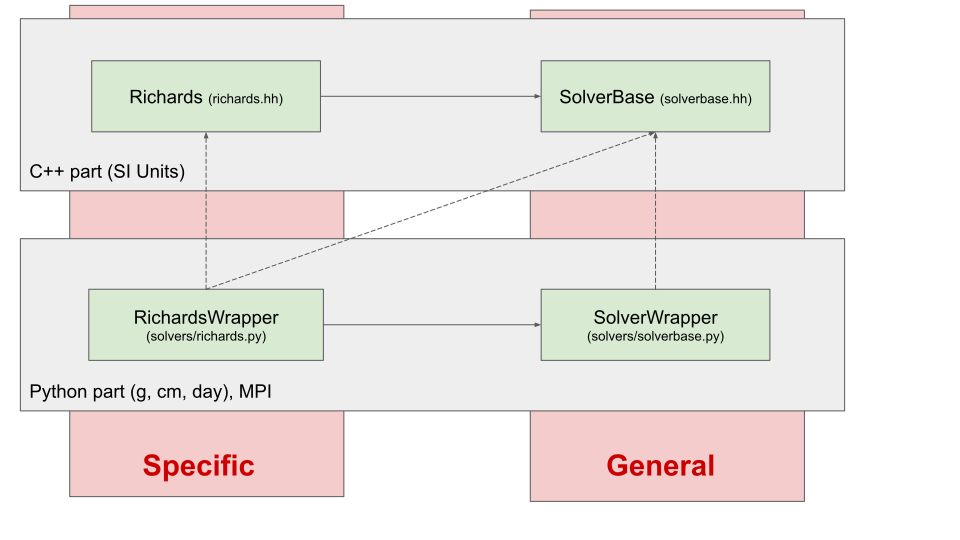

In [10]:
display(SVG(filename='dumux-rosi.svg'))

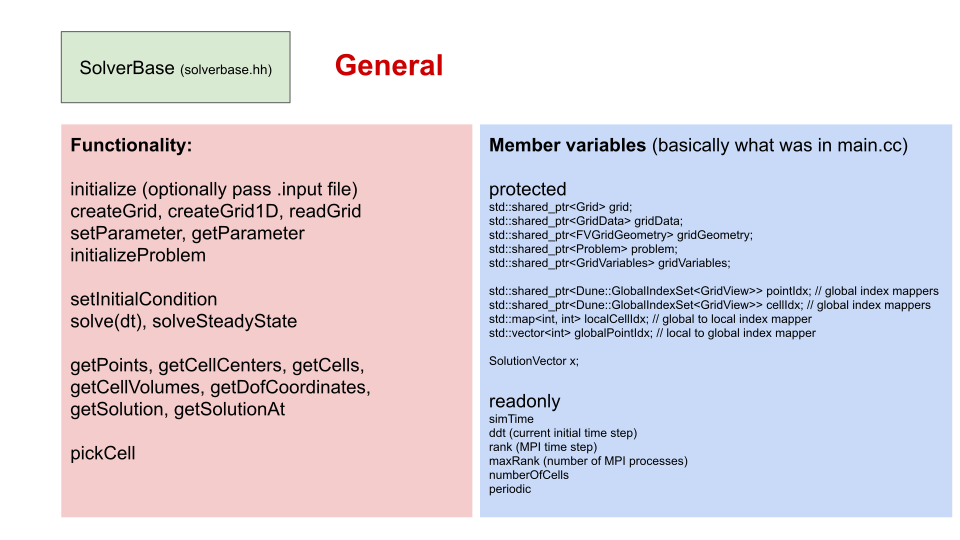

In [12]:
display(SVG(filename='dumux-rosi2.svg'))

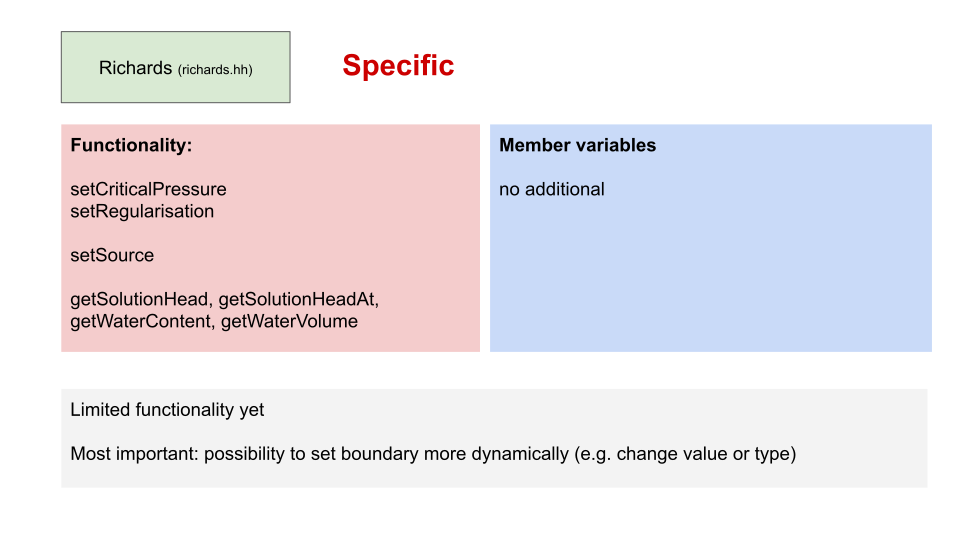

In [13]:
display(SVG(filename='dumux-rosi3.svg'))

## Take away messages

Some idea how to couple the root system simulation with DuMux using DuMux-Rosi.

## Further topics

* Parallelisation (essential if we have a finer soil resolution), DuMux uses MPI, works in DuMux-Rosi

* Where to find what in the C++ code

* Coupling to 1D axisymmetric modes, to represent the rhizosphere, e.g. Water and phosphate, TH Mai et al. (2020) Annals of Botany 

* Coupling to steady rate solutions of 1D axisymmetric Richards equation (T Schröder et al. (2008) Vadose Zone Journal; J Vanderborght et al. (2021) HESS, preprint)
